# Comparing Sentiment analysis Models


1. BERT (Bidirectional Encoder Representations from Transformers)
2. RoBERTa (Robustly Optimized BERT approach) Pretrained Model from 🤗
3. Huggingface Pipeline


## Reading the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
plt.style.use('ggplot')

# Bert
!pip install transformers requests beautifulsoup4 pandas numpy
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

#Roberta
# from transformers import AutoTokenizer
# from transformers import AutoModelForSequenceClassification
from scipy.special import softmax 

# Pipeline
from transformers import pipeline


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


c:\Users\nachi\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read in data
df = pd.read_csv('C:/Users/nachi/Desktop/test projects/Sentiment analysis/Reviews/Reviews.csv')
df = df.head(30)
df.head()
example = df['Text'][3]

In [3]:
# If u want to import file in jupiter notebook via google drive
# from google.colab import drive
# drive.mount('/content/drive/')
# df = pd.read_csv('/content/drive/MyDrive/Reviews.csv')

### 1. Bert Model

In [4]:
tokenizer_b = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model_b = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [5]:
# Helper function to assign sentiment
def assign_senti(score):
    if score <= 2 :
        final_b="Negative"
    elif score == 3:
        final_b="Neutral"
    elif score >= 4:
        final_b= "Positive"
    return final_b

In [6]:
def BERT_score(review):
    tokens = tokenizer_b.encode(review, return_tensors='pt')
    
    tokenizer_b.decode(tokens[0])
    result = model_b(tokens)
    score = int(torch.argmax(result.logits))+1

    final_ber = assign_senti(score)

    scores_dict = {
        'BERT_score' : score,
        'BERT Emotion': final_ber}
    return scores_dict

# BERT_score("this is best")

### 2. RoBERTa Pretrained Model

- Uses a model trained of a large corpus of data.
- Transformer model accounts for the words but also the context related to other words.

In [7]:
tokenizer_r = AutoTokenizer.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')
model_r = AutoModelForSequenceClassification.from_pretrained('cardiffnlp/twitter-roberta-base-sentiment')

In [8]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer_r(example, return_tensors='pt')
    output = model_r(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # assigns a sentiment 
    if scores[0] > scores[1] and scores[0] > scores[2]:
        final_sc="Negative"
    elif scores[1] > scores[0] and scores[1] > scores[2]:
        final_sc="Neutral"
    elif scores[2] > scores[0] and scores[2] > scores[1]:
        final_sc= "Positive"

    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2],
        'Roberto Emotion': final_sc
    }
    return scores_dict

### 3. The Transformers Pipeline


In [9]:
sent_pipeline = pipeline("sentiment-analysis")
def polarity_scores_pipeline(example):
   a = sent_pipeline(example)[0]["label"].lower
   pp = {'Pipeline Emotion' : sent_pipeline(example)[0]["label"]}
   return pp

# polarity_scores_pipeline("Hey i dislike you")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


## Combining the Sentiment results

In [10]:

from tqdm import tqdm
res = {}
tes = {} 
ber = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        pipeline_results = polarity_scores_pipeline(text)
        roberta_result = polarity_scores_roberta(text)
        BERT_result = BERT_score(text)
        ber[myid] = BERT_result
        res[myid] = roberta_result
        tes[myid] = pipeline_results

        
    except RuntimeError:
        print(f'Broke for id {myid}')

100%|██████████| 30/30 [00:14<00:00,  2.13it/s]


In [11]:
# res
results_rf = pd.DataFrame(res).T
results_pf = pd.DataFrame(tes).T
results_br = pd.DataFrame(ber).T

results_rf = results_rf.join(results_br)
results_rf = results_rf.join(results_pf)


results_rf = results_rf.reset_index().rename(columns={'index': 'Id'})
final = results_rf.merge(df, how='left')

final



,Id,roberta_neg,roberta_neu,roberta_pos,Roberto Emotion,BERT_score,BERT Emotion,Pipeline Emotion,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.009624,0.04998,0.940395,Positive,5,Positive,POSITIVE,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.508986,0.452414,0.0386,Negative,1,Negative,NEGATIVE,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.003229,0.098067,0.898704,Positive,5,Positive,POSITIVE,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.002295,0.090219,0.907486,Positive,5,Positive,POSITIVE,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.001635,0.010302,0.988063,Positive,5,Positive,POSITIVE,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
5,6,0.00613,0.021796,0.972075,Positive,4,Positive,POSITIVE,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,I got a wild hair for taffy and ordered this f...
6,7,0.001305,0.007774,0.990921,Positive,5,Positive,POSITIVE,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...
7,8,0.002029,0.005685,0.992285,Positive,5,Positive,POSITIVE,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...
8,9,0.003874,0.094156,0.90197,Positive,5,Positive,POSITIVE,B000E7L2R4,A1MZYO9TZK0BBI,R. James,1,1,5,1322006400,Yay Barley,Right now I'm mostly just sprouting this so my...
9,10,0.003103,0.055912,0.940984,Positive,4,Positive,POSITIVE,B00171APVA,A21BT40VZCCYT4,Carol A. Reed,0,0,5,1351209600,Healthy Dog Food,This is a very healthy dog food. Good for thei...


## Compare Scores between models

In [12]:

# print(final.Text[16])
final.loc[:,['ProfileName','Text','BERT_score','BERT Emotion','Roberto Emotion','Pipeline Emotion','Score']]

,ProfileName,Text,BERT_score,BERT Emotion,Roberto Emotion,Pipeline Emotion,Score
0,delmartian,I have bought several of the Vitality canned d...,5,Positive,Positive,POSITIVE,5
1,dll pa,Product arrived labeled as Jumbo Salted Peanut...,1,Negative,Negative,NEGATIVE,1
2,"Natalia Corres ""Natalia Corres""",This is a confection that has been around a fe...,5,Positive,Positive,POSITIVE,4
3,Karl,If you are looking for the secret ingredient i...,5,Positive,Positive,POSITIVE,2
4,"Michael D. Bigham ""M. Wassir""",Great taffy at a great price. There was a wid...,5,Positive,Positive,POSITIVE,5
5,Twoapennything,I got a wild hair for taffy and ordered this f...,4,Positive,Positive,POSITIVE,4
6,David C. Sullivan,This saltwater taffy had great flavors and was...,5,Positive,Positive,POSITIVE,5
7,Pamela G. Williams,This taffy is so good. It is very soft and ch...,5,Positive,Positive,POSITIVE,5
8,R. James,Right now I'm mostly just sprouting this so my...,5,Positive,Positive,POSITIVE,5
9,Carol A. Reed,This is a very healthy dog food. Good for thei...,4,Positive,Positive,POSITIVE,5


## Ploting

In [15]:
ber_counts = final['BERT Emotion'].value_counts()
Rob_counts = final['Roberto Emotion'].value_counts()
Pipe_counts = final['Pipeline Emotion'].value_counts()
# print(f"ber:{ber_counts} \n rob:{Rob_counts} \n pipe:{Pipe_counts}")

n,p,nu=0,0,0
for r in tqdm(final['Score']):
  # print(assign_senti(r))
  if assign_senti(r) == 'Negative':
    n+=1
  elif assign_senti(r) == 'Positive':
    p+=1
  elif assign_senti(r) == 'Neutral':
    nu+=1



if 'Neutral' not in ber_counts:
  ber_counts['Neutral'] = 0


data = {'BERT Emotion': {'Positive': ber_counts['Positive'], 'Negative': ber_counts['Negative'], 'Neutral': ber_counts['Neutral']},
        'Roberto Emotion': {'Positive': Rob_counts['Positive'], 'Negative': Rob_counts['Negative'], 'Neutral': Rob_counts['Neutral']},
        'Pipeline Emotion': {'Positive': Pipe_counts['POSITIVE'], 'Negative': Pipe_counts['NEGATIVE'], 'Neutral': 0},
        'Initial Emotion':  {'Positive': p, 'Negative': n, 'Neutral': nu} }
        

# data
a= pd.DataFrame(data)

100%|██████████| 30/30 [00:00<?, ?it/s]


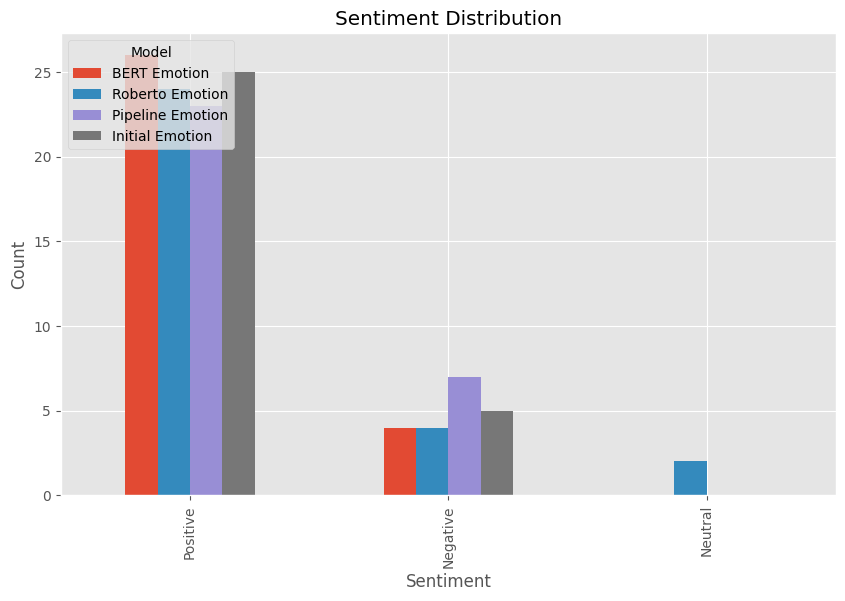

In [20]:
plt.rcParams['figure.figsize'] = [10, 6]
a.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.legend(title='Model', loc='upper left')
plt.show()


1. Can compare Bert score(1-5) with initial score ie. review stars
2. Can check accuracy of the three models by comparing each results to initial scores
3. 